In [2]:
pip install pandas matplotlib


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import xml.etree.ElementTree as ET
import zipfile
import os

# Define the path to the uploaded zip file and the directory to extract to
zip_file_path = 'export.zip'  # Update with the correct path to your export.zip file
extracted_dir_path = 'extracted_apple_health_data'

# Create the directory to extract files
os.makedirs(extracted_dir_path, exist_ok=True)

# Extract the uploaded zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [5]:

export_xml_path = os.path.join(extracted_dir_path, 'apple_health_export', 'export.xml')

In [12]:
# Function to parse the export.xml file
def parse_apple_health_data(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Extract relevant data
    data = []
    for record in root.findall('Record'):
        record_type = record.get('type')
        if 'HKQuantityTypeIdentifier' in record_type:
            data.append({
                'type': record_type,
                'sourceName': record.get('sourceName'),
                'sourceVersion': record.get('sourceVersion'),
                'unit': record.get('unit'),
                'creationDate': record.get('creationDate'),
                'startDate': record.get('startDate'),
                'endDate': record.get('endDate'),
                'value': record.get('value')
            })
    
    # Convert the data into a DataFrame
    df = pd.DataFrame(data)
    return df

In [13]:
df = parse_apple_health_data(export_xml_path)


In [37]:
# Data Cleaning and Preparation
df['creationDate'] = pd.to_datetime(df['creationDate'])
df['startDate'] = pd.to_datetime(df['startDate'])
df['endDate'] = pd.to_datetime(df['endDate'])

# Filter data to focus on relevant activity and fitness metrics
activity_types = [
    'HKQuantityTypeIdentifierStepCount',
    'HKQuantityTypeIdentifierActiveEnergyBurned',
    'HKQuantityTypeIdentifierAppleExerciseTime'
]

activity_data = df[df['type'].isin(activity_types)].copy()

In [38]:
# Convert value to numeric
activity_data['value'] = pd.to_numeric(activity_data['value'], errors='coerce')

# Save the cleaned data for further analysis
activity_data.to_csv('cleaned_activity_data.csv', index=False)

# Display first few rows of the cleaned data
print(activity_data.head())

                                     type sourceName sourceVersion   unit  \
758710  HKQuantityTypeIdentifierStepCount     iPhone          10.2  count   
758711  HKQuantityTypeIdentifierStepCount     iPhone          10.2  count   
758712  HKQuantityTypeIdentifierStepCount     iPhone          10.2  count   
758713  HKQuantityTypeIdentifierStepCount     iPhone          10.2  count   
758714  HKQuantityTypeIdentifierStepCount     iPhone          10.2  count   

                    creationDate                 startDate  \
758710 2016-12-22 15:20:04-04:00 2016-12-22 14:44:20-04:00   
758711 2016-12-22 23:23:21-04:00 2016-12-22 22:56:32-04:00   
758712 2016-12-22 23:23:21-04:00 2016-12-22 23:06:42-04:00   
758713 2016-12-23 00:24:50-04:00 2016-12-22 23:55:16-04:00   
758714 2016-12-23 04:20:13-04:00 2016-12-23 03:37:49-04:00   

                         endDate  value  
758710 2016-12-22 14:50:43-04:00   20.0  
758711 2016-12-22 23:03:06-04:00   19.0  
758712 2016-12-22 23:12:52-04:00   10.

In [39]:
import pandas as pd

# Specify data types to avoid mixed types warning
dtype_spec = {
    'type': str,
    'sourceName': str,
    'sourceVersion': str,
    'unit': str,
    'creationDate': str,
    'startDate': str,
    'endDate': str,
    'value': str
}

# Load cleaned data with specified data types
activity_data = pd.read_csv('cleaned_activity_data.csv', dtype=dtype_spec)

# Ensure the startDate column is in datetime format
activity_data['startDate'] = pd.to_datetime(activity_data['startDate'])

# Inspect unique types
unique_types = activity_data['type'].unique()
print(unique_types)


['HKQuantityTypeIdentifierStepCount'
 'HKQuantityTypeIdentifierActiveEnergyBurned'
 'HKQuantityTypeIdentifierAppleExerciseTime']


Index(['HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierStepCount'],
      dtype='object', name='type')


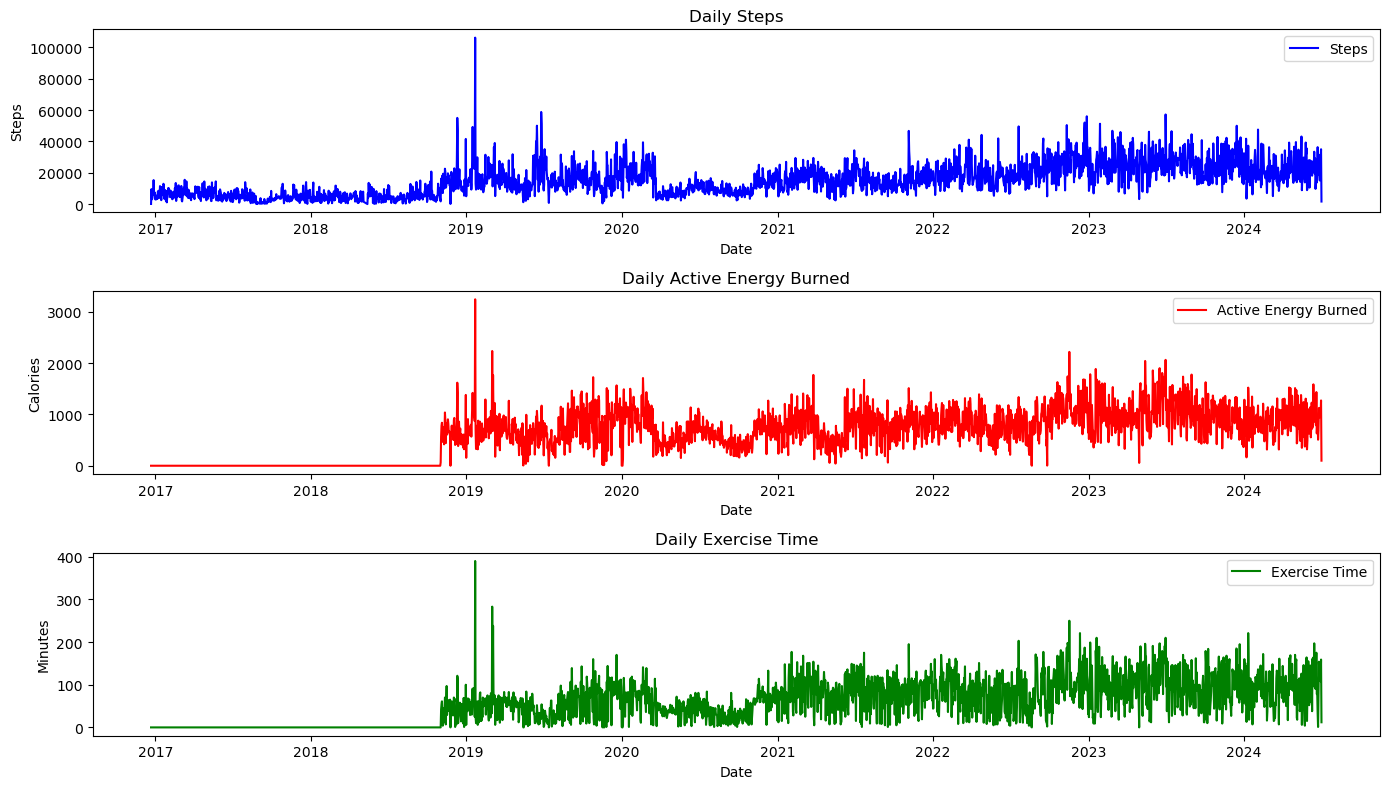

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify data types to avoid mixed types warning
dtype_spec = {
    'type': str,
    'sourceName': str,
    'sourceVersion': str,
    'unit': str,
    'creationDate': str,
    'startDate': str,
    'endDate': str,
    'value': str
}

# Load cleaned data with specified data types
activity_data = pd.read_csv('cleaned_activity_data.csv', dtype=dtype_spec)

# Ensure the date columns are in datetime format
activity_data['startDate'] = pd.to_datetime(activity_data['startDate'])
activity_data['endDate'] = pd.to_datetime(activity_data['endDate'])
activity_data['creationDate'] = pd.to_datetime(activity_data['creationDate'])

# Convert the value column to numeric, coercing errors
activity_data['value'] = pd.to_numeric(activity_data['value'], errors='coerce')

# Aggregate daily data
daily_data = activity_data.groupby([activity_data['startDate'].dt.date, 'type']).agg({
    'value': 'sum'
}).reset_index()

# Pivot data for easier plotting
daily_pivot = daily_data.pivot(index='startDate', columns='type', values='value').fillna(0)

# Check the columns of the pivot table to ensure they exist
print(daily_pivot.columns)

# Define column names based on your inspection results
step_count_col = 'HKQuantityTypeIdentifierStepCount'
energy_burned_col = 'HKQuantityTypeIdentifierActiveEnergyBurned'
exercise_time_col = 'HKQuantityTypeIdentifierAppleExerciseTime'

# Check if the expected columns are present in the pivoted data
if step_count_col not in daily_pivot.columns:
    print(f"Column {step_count_col} is missing from the pivoted data.")
if energy_burned_col not in daily_pivot.columns:
    print(f"Column {energy_burned_col} is missing from the pivoted data.")
if exercise_time_col not in daily_pivot.columns:
    print(f"Column {exercise_time_col} is missing from the pivoted data.")

# Plot daily trends if columns are present
plt.figure(figsize=(14, 8))

if step_count_col in daily_pivot.columns:
    plt.subplot(3, 1, 1)
    plt.plot(daily_pivot.index, daily_pivot[step_count_col], label='Steps', color='blue')
    plt.title('Daily Steps')
    plt.xlabel('Date')
    plt.ylabel('Steps')
    plt.legend()

if energy_burned_col in daily_pivot.columns:
    plt.subplot(3, 1, 2)
    plt.plot(daily_pivot.index, daily_pivot[energy_burned_col], label='Active Energy Burned', color='red')
    plt.title('Daily Active Energy Burned')
    plt.xlabel('Date')
    plt.ylabel('Calories')
    plt.legend()

if exercise_time_col in daily_pivot.columns:
    plt.subplot(3, 1, 3)
    plt.plot(daily_pivot.index, daily_pivot[exercise_time_col], label='Exercise Time', color='green')
    plt.title('Daily Exercise Time')
    plt.xlabel('Date')
    plt.ylabel('Minutes')
    plt.legend()

plt.tight_layout()
plt.show()


In [45]:
import pandas as pd

# Specify data types to avoid mixed types warning
dtype_spec = {
    'type': str,
    'sourceName': str,
    'sourceVersion': str,
    'unit': str,
    'creationDate': str,
    'startDate': str,
    'endDate': str,
    'value': str
}

# Load cleaned data with specified data types
activity_data = pd.read_csv('cleaned_activity_data.csv', dtype=dtype_spec)

# Ensure the date columns are in datetime format
activity_data['startDate'] = pd.to_datetime(activity_data['startDate'], utc=True).dt.tz_localize(None)
activity_data['endDate'] = pd.to_datetime(activity_data['endDate'], utc=True).dt.tz_localize(None)
activity_data['creationDate'] = pd.to_datetime(activity_data['creationDate'], utc=True).dt.tz_localize(None)

# Convert the value column to numeric, coercing errors
activity_data['value'] = pd.to_numeric(activity_data['value'], errors='coerce')

# Define column names
step_count_col = 'HKQuantityTypeIdentifierStepCount'
energy_burned_col = 'HKQuantityTypeIdentifierActiveEnergyBurned'
exercise_time_col = 'HKQuantityTypeIdentifierAppleExerciseTime'

# Aggregate daily data
daily_data = activity_data.groupby([activity_data['startDate'].dt.date, 'type']).agg({
    'value': 'sum'
}).reset_index()

# Pivot data for easier analysis
daily_pivot = daily_data.pivot(index='startDate', columns='type', values='value').fillna(0)

# Daily Statistics
average_steps_per_day = daily_pivot[step_count_col].mean()
average_energy_burned_per_day = daily_pivot[energy_burned_col].mean()
average_exercise_time_per_day = daily_pivot[exercise_time_col].mean()

print(f"Average Steps per Day: {average_steps_per_day}")
print(f"Average Active Energy Burned per Day: {average_energy_burned_per_day}")
print(f"Average Exercise Time per Day: {average_exercise_time_per_day}")

# Aggregate weekly data
weekly_data = activity_data.groupby([activity_data['startDate'].dt.to_period('W').dt.start_time, 'type']).agg({
    'value': 'sum'
}).reset_index()

# Pivot data for easier analysis
weekly_pivot = weekly_data.pivot(index='startDate', columns='type', values='value').fillna(0)

# Check the columns of the weekly pivot table to ensure they exist
print("Weekly Pivot Columns:", weekly_pivot.columns)

# Weekly Statistics
total_steps_per_week = weekly_pivot[step_count_col].sum()
total_energy_burned_per_week = weekly_pivot[energy_burned_col].sum()
total_exercise_time_per_week = weekly_pivot[exercise_time_col].sum()

average_steps_per_week = weekly_pivot[step_count_col].mean()
average_energy_burned_per_week = weekly_pivot[energy_burned_col].mean()
average_exercise_time_per_week = weekly_pivot[exercise_time_col].mean()

print(f"Total Steps per Week: {total_steps_per_week}")
print(f"Total Active Energy Burned per Week: {total_energy_burned_per_week}")
print(f"Total Exercise Time per Week: {total_exercise_time_per_week}")

print(f"Average Steps per Week: {average_steps_per_week}")
print(f"Average Active Energy Burned per Week: {average_energy_burned_per_week}")
print(f"Average Exercise Time per Week: {average_exercise_time_per_week}")

# Aggregate monthly data
monthly_data = activity_data.groupby([activity_data['startDate'].dt.to_period('M').dt.start_time, 'type']).agg({
    'value': 'sum'
}).reset_index()

# Pivot data for easier analysis
monthly_pivot = monthly_data.pivot(index='startDate', columns='type', values='value').fillna(0)

# Check the columns of the monthly pivot table to ensure they exist
print("Monthly Pivot Columns:", monthly_pivot.columns)

# Monthly Statistics
total_steps_per_month = monthly_pivot[step_count_col].sum()
total_energy_burned_per_month = monthly_pivot[energy_burned_col].sum()
total_exercise_time_per_month = monthly_pivot[exercise_time_col].sum()

average_steps_per_month = monthly_pivot[step_count_col].mean()
average_energy_burned_per_month = monthly_pivot[energy_burned_col].mean()
average_exercise_time_per_month = monthly_pivot[exercise_time_col].mean()

print(f"Total Steps per Month: {total_steps_per_month}")
print(f"Total Active Energy Burned per Month: {total_energy_burned_per_month}")
print(f"Total Exercise Time per Month: {total_exercise_time_per_month}")

print(f"Average Steps per Month: {average_steps_per_month}")
print(f"Average Active Energy Burned per Month: {average_energy_burned_per_month}")
print(f"Average Exercise Time per Month: {average_exercise_time_per_month}")


Average Steps per Day: 15234.853649635037
Average Active Energy Burned per Day: 613.139243430657
Average Exercise Time per Day: 56.527372262773724
Weekly Pivot Columns: Index(['HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierStepCount'],
      dtype='object', name='type')
Total Steps per Week: 41743499.0
Total Active Energy Burned per Week: 1680001.527
Total Exercise Time per Week: 154885.0
Average Steps per Week: 106217.55470737914
Average Active Energy Burned per Week: 4274.813045801527
Average Exercise Time per Week: 394.10941475826974
Monthly Pivot Columns: Index(['HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierStepCount'],
      dtype='object', name='type')
Total Steps per Month: 41743499.0
Total Active Energy Burned per Month: 1680001.527
Total Exercise Time per Month: 154885.0
Average Steps per Month: 453733.6847826087

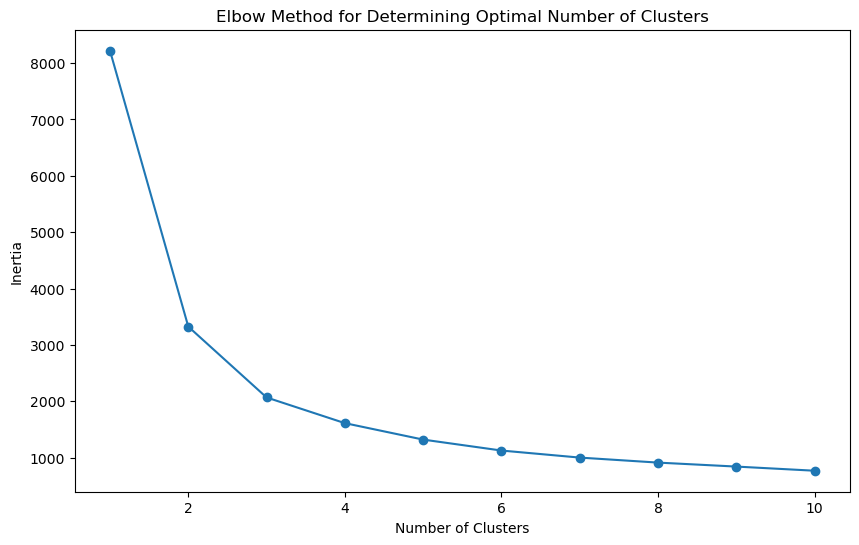

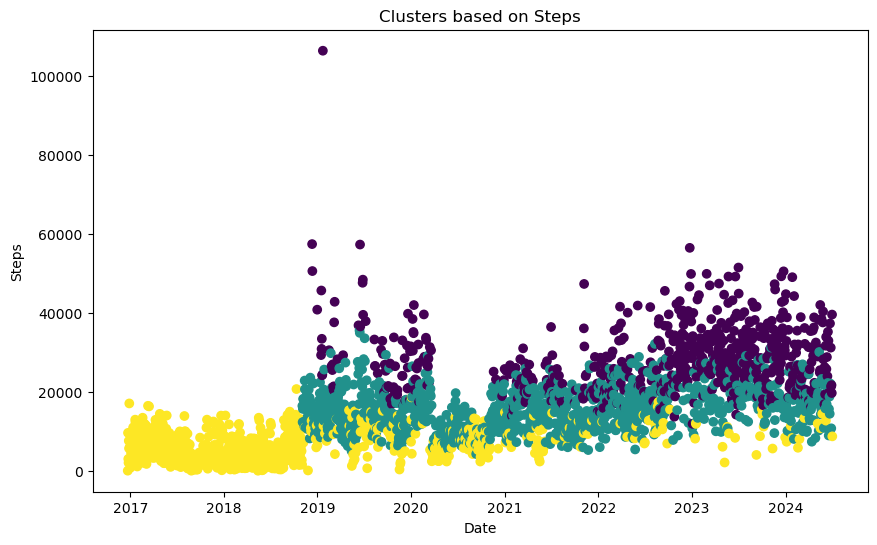

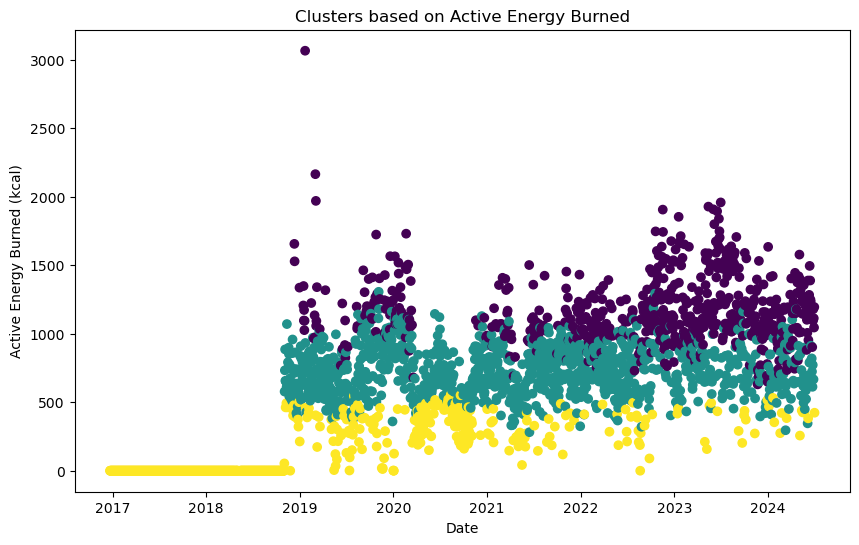

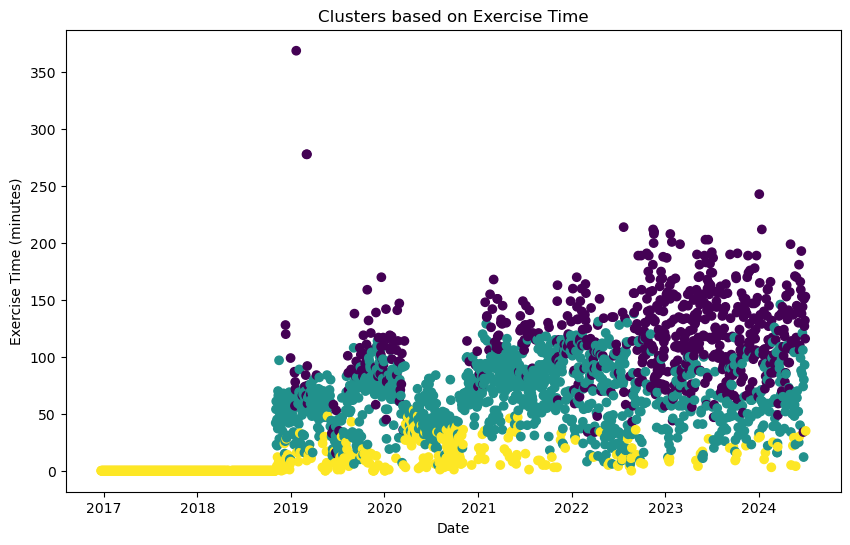

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Prepare data for clustering
clustering_data = daily_pivot[[step_count_col, energy_burned_col, exercise_time_col]].copy()

# Standardize the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Determine the optimal number of clusters using the elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, n_init=10, random_state=42)  # Set n_init explicitly
    kmeans.fit(clustering_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal number of clusters (e.g., 3)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)  # Set n_init explicitly
daily_pivot['Cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(daily_pivot.index, daily_pivot[step_count_col], c=daily_pivot['Cluster'], cmap='viridis')
plt.title('Clusters based on Steps')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(daily_pivot.index, daily_pivot[energy_burned_col], c=daily_pivot['Cluster'], cmap='viridis')
plt.title('Clusters based on Active Energy Burned')
plt.xlabel('Date')
plt.ylabel('Active Energy Burned (kcal)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(daily_pivot.index, daily_pivot[exercise_time_col], c=daily_pivot['Cluster'], cmap='viridis')
plt.title('Clusters based on Exercise Time')
plt.xlabel('Date')
plt.ylabel('Exercise Time (minutes)')
plt.show()


Mean Squared Error: 66925420.38898187


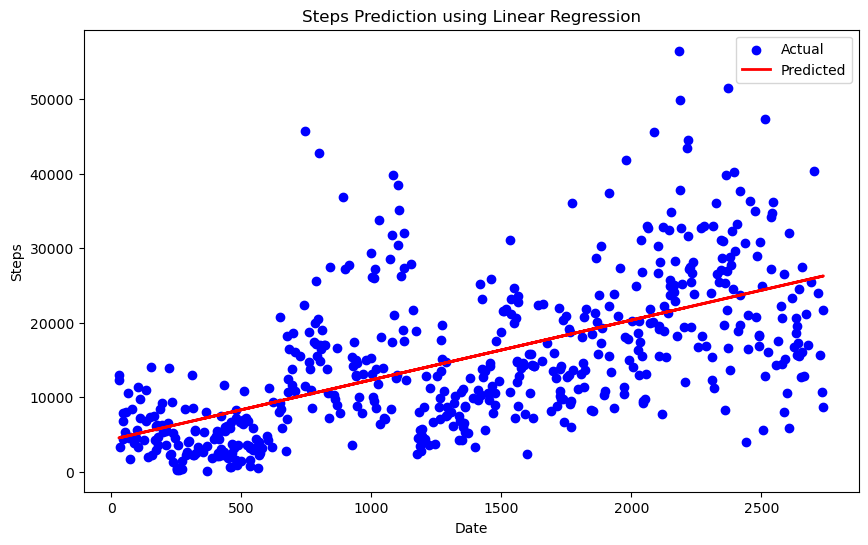

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare data for regression
X = daily_pivot.index.factorize()[0].reshape(-1, 1)  # Convert dates to numerical format
y_steps = daily_pivot[step_count_col]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_steps, test_size=0.2, random_state=42)

# Train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.title('Steps Prediction using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.legend()
plt.show()


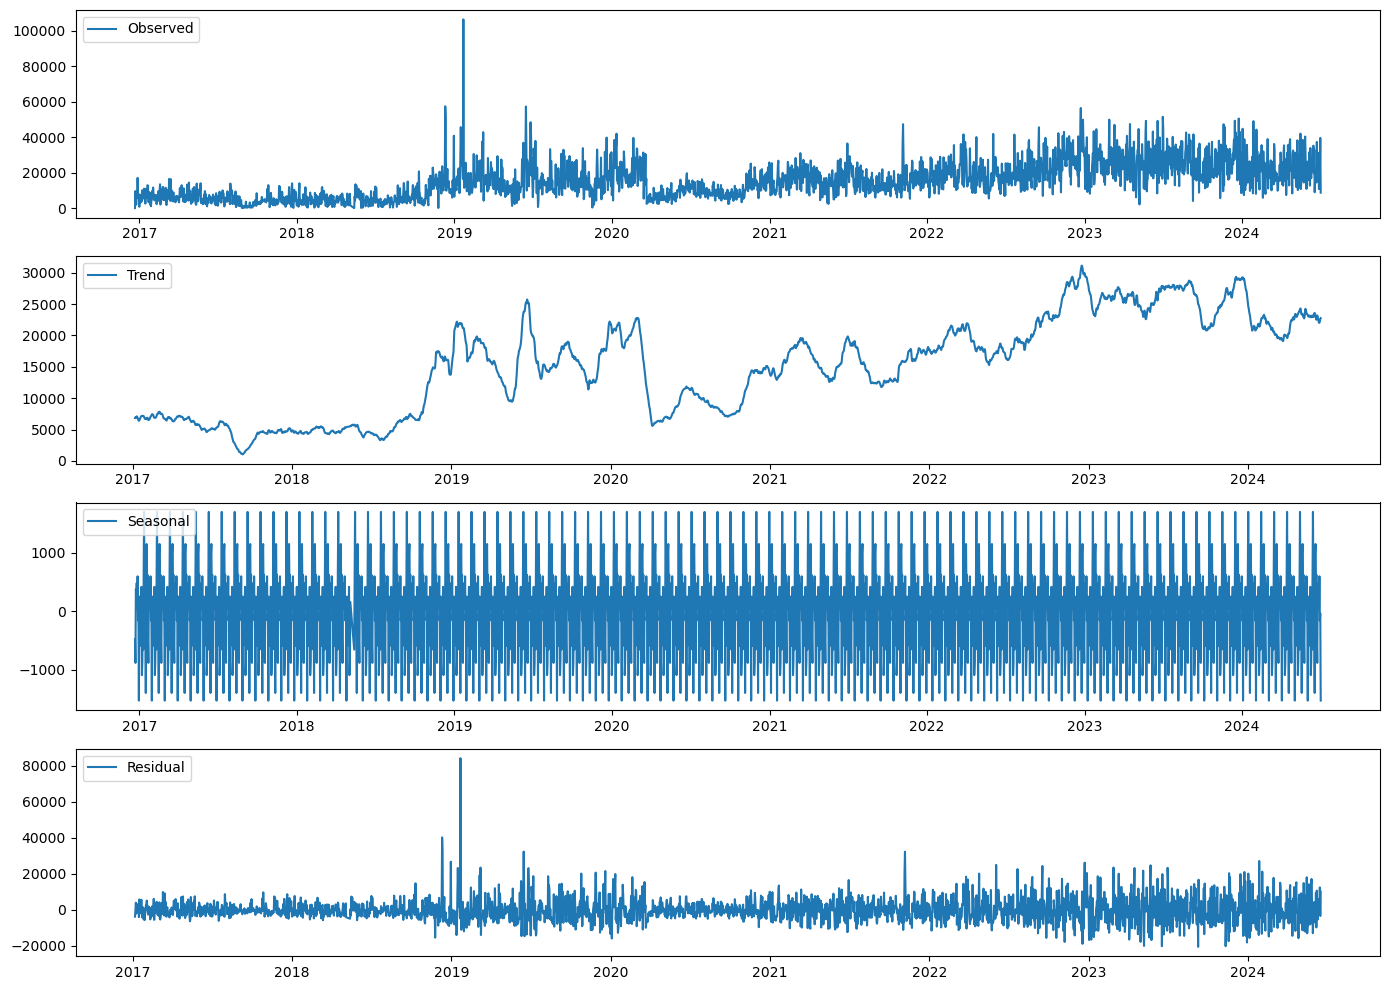

In [50]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the data for time series decomposition
steps_ts = daily_pivot[step_count_col]

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(steps_ts, model='additive', period=30)

# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


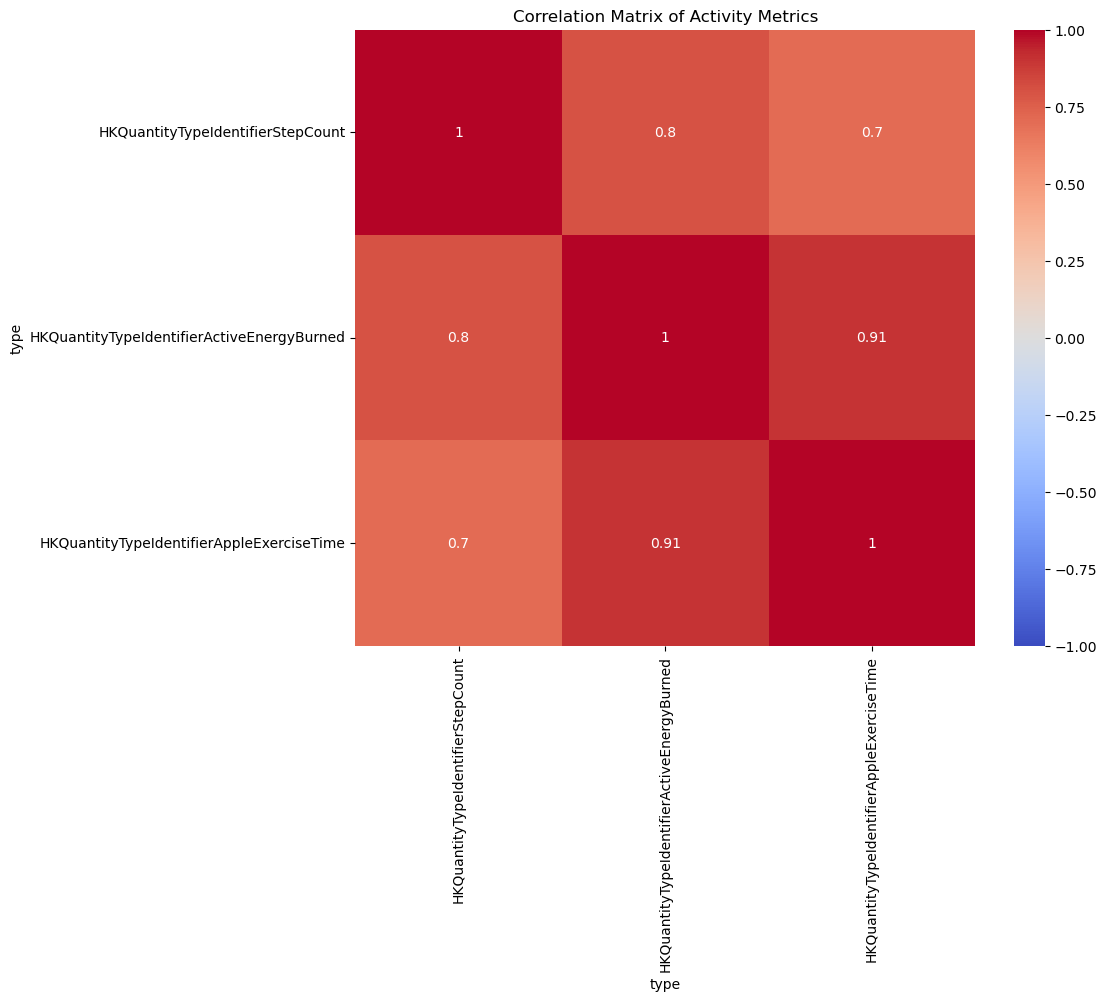

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = daily_pivot[[step_count_col, energy_burned_col, exercise_time_col]].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Activity Metrics')
plt.show()


In [52]:
import plotly.express as px

# Interactive line plot for steps
fig = px.line(daily_pivot, x=daily_pivot.index, y=step_count_col, title='Daily Steps', labels={'x': 'Date', 'y': 'Steps'})
fig.show()

# Interactive line plot for active energy burned
fig = px.line(daily_pivot, x=daily_pivot.index, y=energy_burned_col, title='Daily Active Energy Burned', labels={'x': 'Date', 'y': 'Active Energy Burned (kcal)'})
fig.show()

# Interactive line plot for exercise time
fig = px.line(daily_pivot, x=daily_pivot.index, y=exercise_time_col, title='Daily Exercise Time', labels={'x': 'Date', 'y': 'Exercise Time (minutes)'})
fig.show()
